主要是手动实现的这部分

TODO

- action 部分添加
- 正常状态
- 反归一化状态
- 统一在格网中显示操作

### theo 归一化代码了

In [ ]:
"""直接可以进行运行

"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

from gym import Env
from collections import OrderedDict

class DynEnv(Env):

    initials = dict(L=2480.,
               A=758, #830 ,
               G=1125,
               T=5.05e-6,
               P=6e9,
               K=6e13,
               S=5e11
               )
    params = dict(Sigma=1.5 * 1e8,
                Cstar=5500,
                a0=0.0298,
                aT=3200,
                l0=26.4,
                lT=1.1 * 1e6,
                delta=0.01,
                m=1.5,
                g=0.02, # greenhouse effect
                p=0.04,
                Wp=2000,
                q0=20,
                b=5.4 * 1e-7,
                yE=120,#147
                eB=4 * 1e10,
                eF=4 * 1e10,
                i=0.25,
                wL=0, #value varied
                k0=0.1,
                aB=1.5e4,#3e5,#value varied
                aF=2.7e5, #5e6, #value varied
                aR=9e-15, #7e-18, #?
                sS=1. / 50., #?
                sR=1.,#?
                ren_sub=.5,
                carbon_tax=.5,
                L0=2480.,
                )

    def __init__(self, action_number=3, reward_type=None):

        # Initialise class variables
        self.dt = 1
        self.action_number = action_number
        self.observation_space = len(self.initials.keys())

        self.carbon_tax = 0.5
        self.ren_sub = 0.5
        # self.cull = 1e7

        # We initialise the environment with a reset
        _ = self.reset()

        # Get the reward type
        self.reward_type = reward_type
        self.reward_function = self.get_reward_function(reward_type)

        # Planetary boundaries
        self.A_PB = 945
        self.W_PB = 7850
        self.P_PB = None
        self.PB_vec = np.array([self.A_PB, self.W_PB, self.P_PB])

    def step(self, action_t) -> (np.array, float, bool):
        """The main step function where we call the others from"""

        # 这是来源于其他的部分补充的组件部分
        next_t = self.t + self.dt

        # we adjust the parameters given the actions taken
        # 开始时候操作我们定义为 action_0
        self.adjust_parameters(action_t)

        # we call the ode solver with the new parameters
        self.state = self.ode_solver(next_t)

        # Check if we have reached a final state
        if self.state_is_final():
            self.final_state = True

        reward = self.reward_function()
        self.t = next_t

        # 只有 state 需要正则化
        return self.normalise(self.state), reward, self.final_state

    def reset(self):
        """Resetting the environment at the start of an episode"""

        self.state = np.array(list(self.initials.values()))
        self.t = 0
        self.final_state = False
        self.np = False
        self.adjust_parameters()

        return self.state

    def ode_solver(self, next_t) -> np.array:
        """This is where we solve the dynamical system of equations to get the next state"""

        # we use the scipy ode solver: odeint
        ode_solutions = odeint(func=self.dynamic_eqs,
                               y0=self.state,
                               t=[self.t, next_t],
                               mxstep=10000)

        # we take the values of the variables on the last time step as our next state
        return ode_solutions[-1, :]

    def dynamic_eqs(self, LAGTPKS, t) -> list:
        """The differential equations we have to solve for the next step"""

        # We define variables for simpler notation
        def phot(A, T):
            """Photosynthesis"""
            return (self.params['l0'] - self.params['lT'] * T) * np.sqrt(A / self.params['Sigma'])

        def resp(T):
            """Respiration"""
            return self.params['a0'] + self.params['aT'] * T

        def diff(L, A, G=0.):
            """Diffusion between atmosphere and ocean"""
            return self.params['delta'] * (self.params['Cstar'] - L - G - (1 + self.params['m']) * A)

        def fert(W):
            """Human fertility rate"""
            return 2 * self.params['p'] * self.params['Wp'] * W / (self.params['Wp']**2 + W**2)

        def mort(W):
            """Human mortality rate"""
            return self.params['q0'] / W + self.params['wL']/self.params['Sigma']

        # We unpack the state variables and derived variables
        L, A, G, T, P, K, S = LAGTPKS
        
        B, F, R, Y, W = self.compute_derived_variables()

        # clamp here
        L = np.amin([np.amax([L, 1e-12]), self.params['Cstar']])
        A = np.amin([np.amax([A, 1e-12]), self.params['Cstar']])
        G = np.amin([np.amax([G, 1e-12]), self.params['Cstar']])
        T = np.amax([T, 1e-12])
        P = np.amax([P, 1e-12])
        K = np.amax([K, 1e-12])
        S = np.amax([S, 1e-12])

        # odes to solve
        dL = (phot(A, T) - resp(T)) * L - B
        dA = -dL + diff(L, A, G=G)
        dG = -F
        dT = self.params['g'] * (A / self.params['Sigma'] - T)
        dP = P * (fert(W) - mort(W))
        dK = self.params['i'] * Y - self.params['k0'] * K
        dS = self.params['sR'] * R - self.params['sS'] * S

        return [dL, dA, dG, dT, dP, dK, dS] # 关键的 ode 计算的部分

    def compute_derived_variables(self) -> tuple:
        """Compute the variables that depend on the state variables"""

        # Unpack state variables
        L, A, G, T, P, K, S = self.state

        if self.np:
            Leff = max(L-self.params['L0'], 0)
        else:
            Leff = L

        # Recurrent variables for simpler computation
        Xb = self.params['aB'] * Leff ** 2.
        Xf = self.params['aF'] * G ** 2.
        Xr = self.params['aR'] * S ** 2.
        X = Xb + Xf + Xr
        Z = (P * K) ** (2 / 5) / X ** (4 / 5)

        # derived variables
        B = Xb * Z / self.params['eB']
        F = Xf * Z / self.params['eF']
        R = Xr * Z
        Y = self.params['yE'] * (self.params['eB'] * B + self.params['eF'] * F + R)
        W = (1. - self.params['i']) * Y / P + self.params['wL'] * Leff / self.params['Sigma']

        return B, F, R, Y, W

    def adjust_parameters(self, a_t=0):
        """Adjust the parameters before computing the ODE by using the actions"""
        # 它的作用是将整数a_t转换为其对应的二进制表示，并以列表的形式返回。
        # ['0', '1', '0']
        action = (list(np.binary_repr(a_t, width=self.action_number)))
        action.reverse() # 为了使列表中的二进制位按照正确的顺序排列

        aR_default = 7e-18
        aF_default = 5e6
        aB_default = 3e5
        # # TODO extend this to multiple dimensions
        # self.params['aR'] = aR_default * (1 + 0.3*action[0])
        # self.params['aB'] = aB_default * (1 + 0.3*action[1])
        # self.params['aF'] = aF_default * (1 + 0.3*action[2])
        if int(action[0]):
            self.params['aR'] = aR_default*(1+self.ren_sub)
        else:
            self.params['aR'] = aR_default
        # carbon tax
        if int(action[1]):
            self.params['aB'] = aB_default*(1-self.carbon_tax)
            self.params['aF'] = aF_default*(1-self.carbon_tax)
        else:
            self.params['aB'] = aB_default
            self.params['aF'] = aF_default

        # 我猜是其中基本保护的部分操作
        if int(action[2]):
            self.np = True
        else:
            self.np = False

        # if int(action[3]):
        #     self.state[4] -= self.cull



    def normalise(self, cur_state):
        return np.array(cur_state)/(np.array(list(self.initials.values()))+np.array(cur_state))
        # return np.array(cur_state)        

    def get_env(self, env_type):
        pass

    def get_reward_function(self, reward_type):
        """Choosing a reward function"""


        def planet_boundaries():
            _, A, _, _, P, _, _ = self.state
            # _, _, _, _, W = self.compute_derived_variables()
            # state_vec = np.array([A, W/18588, P])
            # r_t = np.linalg.norm(state_vec - self.PB_vec)
            if self.inside_planetary_boundaries():
                return round(np.sqrt(self.A_PB - A), 1)
            return 0

        return planet_boundaries

    def state_is_final(self) -> bool:
        """Check to see if we are in a terminal state"""

        if not self.inside_planetary_boundaries():
            return True
        return False
    
    

    def inside_planetary_boundaries(self) -> bool:
        """Check if we are inside the planetary boundaries"""
        self.adjust_parameters()
        _, A, _, _, P, _, _ = self.state
        _, _, _, _, W = self.compute_derived_variables()

        if A < self.A_PB: #and W > self.W_PB and P > self.P_PB:
            return True
        return False

env = DynEnv()
states = []
actions = []

# 代码表示依次添加 5 遍 5
# 依次添加10遍4
# 依次添加2遍7
# 依次添加40遍4
# 依次添加2遍7
# 依次添加100遍6
# 5+10+2+40+2+100=159
[actions.append(0) for i in range(100)]
# [actions.append(4) for i in range(10)]
# [actions.append(7) for i in range(2)]
# [actions.append(4) for i in range(40)]
# [actions.append(7) for i in range(2)]
# [actions.append(6) for i in range(100)]

# print(actions)

# 这是基本循环的部分
for i in range(10):
    state, reward, done = env.step(actions[i])
    # 注意其中单步的 state 和 states 不一样
    states.append(state[0:])
    print(env.state)
    if done:
        # 有可能是提前结束了
        print(i, 'done')
        break


# 将所有的 states 都反归一化操作

# 绘制 actions
# plt.plot(actions)
plt.plot(np.array(states)*2, label=("L","A","G","T","P","K", "S"))

plt.legend()
plt.show()

#

### lx 处理绘图代码操作

具体形式：

通过每次归一化之前记录数值，然后单独对其进行绘制

- 逆转了二元组部分
- action 可以多组进行定义操作

In [6]:
"""直接可以进行运行

"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

from gym import Env
from collections import OrderedDict

class DynEnv(Env):

    initials = dict(L=2480.,
               A=758, #830 ,
               G=1125,
               T=5.05e-6,
               P=6e9,
               K=6e13,
               S=5e11
               )
    params = dict(Sigma=1.5 * 1e8,
                Cstar=5500,
                a0=0.0298,
                aT=3200,
                l0=26.4,
                lT=1.1 * 1e6,
                delta=0.01,
                m=1.5,
                g=0.02, # greenhouse effect
                p=0.04,
                Wp=2000,
                q0=20,
                b=5.4 * 1e-7,
                yE=120,#147
                eB=4 * 1e10,
                eF=4 * 1e10,
                i=0.25,
                wL=0, #value varied
                k0=0.1,
                aB=1.5e4,#3e5,#value varied
                aF=2.7e5, #5e6, #value varied
                aR=9e-15, #7e-18, #?
                sS=1. / 50., #?
                sR=1.,#?
                ren_sub=.5,
                carbon_tax=.5,
                L0=2480.,
                )

    def __init__(self, action_number=3, reward_type=None):

        # Initialise class variables
        self.dt = 1
        self.action_number = action_number
        self.observation_space = len(self.initials.keys())

        self.carbon_tax = 0.5
        self.ren_sub = 0.5
        # self.cull = 1e7

        # We initialise the environment with a reset
        _ = self.reset()

        # Get the reward type
        self.reward_type = reward_type
        self.reward_function = self.get_reward_function(reward_type)

        # Planetary boundaries
        self.A_PB = 945
        self.W_PB = 7850
        self.P_PB = None
        self.PB_vec = np.array([self.A_PB, self.W_PB, self.P_PB])

    def step(self, action_t) -> (np.array, float, bool):
        """The main step function where we call the others from"""

        # 这是来源于其他的部分补充的组件部分
        next_t = self.t + self.dt

        # we adjust the parameters given the actions taken
        # 开始时候操作我们定义为 action_0
        self.adjust_parameters(action_t)

        # we call the ode solver with the new parameters
        self.state = self.ode_solver(next_t)

        # Check if we have reached a final state
        if self.state_is_final():
            self.final_state = True

        reward = self.reward_function()
        self.t = next_t

        # 只有 state 需要正则化
        return self.normalise(self.state), reward, self.final_state

    def reset(self):
        """Resetting the environment at the start of an episode"""

        self.state = np.array(list(self.initials.values()))
        self.t = 0
        self.final_state = False
        self.np = False
        self.adjust_parameters()

        return self.state

    def ode_solver(self, next_t) -> np.array:
        """This is where we solve the dynamical system of equations to get the next state"""

        # we use the scipy ode solver: odeint
        ode_solutions = odeint(func=self.dynamic_eqs,
                               y0=self.state,
                               t=[self.t, next_t],
                               mxstep=10000)

        # we take the values of the variables on the last time step as our next state
        return ode_solutions[-1, :]

    def dynamic_eqs(self, LAGTPKS, t) -> list:
        """The differential equations we have to solve for the next step"""

        # We define variables for simpler notation
        def phot(A, T):
            """Photosynthesis"""
            return (self.params['l0'] - self.params['lT'] * T) * np.sqrt(A / self.params['Sigma'])

        def resp(T):
            """Respiration"""
            return self.params['a0'] + self.params['aT'] * T

        def diff(L, A, G=0.):
            """Diffusion between atmosphere and ocean"""
            return self.params['delta'] * (self.params['Cstar'] - L - G - (1 + self.params['m']) * A)

        def fert(W):
            """Human fertility rate"""
            return 2 * self.params['p'] * self.params['Wp'] * W / (self.params['Wp']**2 + W**2)

        def mort(W):
            """Human mortality rate"""
            return self.params['q0'] / W + self.params['wL']/self.params['Sigma']

        # We unpack the state variables and derived variables
        L, A, G, T, P, K, S = LAGTPKS
        
        B, F, R, Y, W = self.compute_derived_variables()

        # clamp here
        L = np.amin([np.amax([L, 1e-12]), self.params['Cstar']])
        A = np.amin([np.amax([A, 1e-12]), self.params['Cstar']])
        G = np.amin([np.amax([G, 1e-12]), self.params['Cstar']])
        T = np.amax([T, 1e-12])
        P = np.amax([P, 1e-12])
        K = np.amax([K, 1e-12])
        S = np.amax([S, 1e-12])

        # odes to solve
        dL = (phot(A, T) - resp(T)) * L - B
        dA = -dL + diff(L, A, G=G)
        dG = -F
        dT = self.params['g'] * (A / self.params['Sigma'] - T)
        dP = P * (fert(W) - mort(W))
        dK = self.params['i'] * Y - self.params['k0'] * K
        dS = self.params['sR'] * R - self.params['sS'] * S

        return [dL, dA, dG, dT, dP, dK, dS] # 关键的 ode 计算的部分

    def compute_derived_variables(self) -> tuple:
        """Compute the variables that depend on the state variables"""

        # Unpack state variables
        L, A, G, T, P, K, S = self.state

        if self.np:
            Leff = max(L-self.params['L0'], 0)
        else:
            Leff = L

        # Recurrent variables for simpler computation
        Xb = self.params['aB'] * Leff ** 2.
        Xf = self.params['aF'] * G ** 2.
        Xr = self.params['aR'] * S ** 2.
        X = Xb + Xf + Xr
        Z = (P * K) ** (2 / 5) / X ** (4 / 5)

        # derived variables
        B = Xb * Z / self.params['eB']
        F = Xf * Z / self.params['eF']
        R = Xr * Z
        Y = self.params['yE'] * (self.params['eB'] * B + self.params['eF'] * F + R)
        W = (1. - self.params['i']) * Y / P + self.params['wL'] * Leff / self.params['Sigma']

        return B, F, R, Y, W

    def adjust_parameters(self, a_t=0):
        """Adjust the parameters before computing the ODE by using the actions"""
        # 它的作用是将整数a_t转换为其对应的二进制表示，并以列表的形式返回。
        # ['0', '1', '0']
        # 随机转换的 2元组
        # action = (list(np.binary_repr(a_t, width=self.action_number)))
        # action.reverse() # 为了使列表中的二进制位按照正确的顺序排列
        
        # 翻译 action 变为 [0,0,0] 形式
        if a_t == 0:
            action = [0,0,0]
            print('action 0, default')
        elif a_t == 1:
            action = [0,1,1]
            print('action 1, sbsidy')
        elif a_t == 2:
            action = [1,0,1]
            print('action 2, carbon tax')
        elif a_t == 3:
            action = [1,1,0]
            print('action 3, natural protection')
        elif a_t == 4:
            action = [0,0,1]
            print('action 4, subsidy and carbon tax')
        elif a_t == 5:
            action = [0,1,0]
            print('action 5, subsidy and natural protection')
        elif a_t == 6:
            action = [1,0,0]
            print('action 6, carbon tax and natural protection')
        elif a_t == 7:
            action = [1,1,1]
            print('action 7, all')
        
    
        aR_default = 7e-18
        aF_default = 5e6
        aB_default = 3e5
        # # TODO extend this to multiple dimensions
        # self.params['aR'] = aR_default * (1 + 0.3*action[0])
        # self.params['aB'] = aB_default * (1 + 0.3*action[1])
        # self.params['aF'] = aF_default * (1 + 0.3*action[2])
        if int(action[0]):
            self.params['aR'] = aR_default*(1+self.ren_sub)
        else:
            self.params['aR'] = aR_default
        # carbon tax
        if int(action[1]):
            self.params['aB'] = aB_default*(1-self.carbon_tax)
            self.params['aF'] = aF_default*(1-self.carbon_tax)
        else:
            self.params['aB'] = aB_default
            self.params['aF'] = aF_default

        # 我猜是其中基本保护的部分操作
        if int(action[2]):
            self.np = True
        else:
            self.np = False

        # if int(action[3]):
        #     self.state[4] -= self.cull



    def normalise(self, cur_state):
        return np.array(cur_state)/(np.array(list(self.initials.values()))+np.array(cur_state))
        # return np.array(cur_state)        

    def get_env(self, env_type):
        pass

    def get_reward_function(self, reward_type):
        """Choosing a reward function"""


        def planet_boundaries():
            _, A, _, _, P, _, _ = self.state
            # _, _, _, _, W = self.compute_derived_variables()
            # state_vec = np.array([A, W/18588, P])
            # r_t = np.linalg.norm(state_vec - self.PB_vec)
            if self.inside_planetary_boundaries():
                return round(np.sqrt(self.A_PB - A), 1)
            return 0

        return planet_boundaries

    def state_is_final(self) -> bool:
        """Check to see if we are in a terminal state"""

        if not self.inside_planetary_boundaries():
            return True
        return False
    
    

    def inside_planetary_boundaries(self) -> bool:
        """Check if we are inside the planetary boundaries"""
        self.adjust_parameters()
        _, A, _, _, P, _, _ = self.state
        _, _, _, _, W = self.compute_derived_variables()

        if A < self.A_PB: #and W > self.W_PB and P > self.P_PB:
            return True
        return False

env = DynEnv()
states = []
actions = []


# default
# [actions.append(0) for i in range(100)]

# carbon tax 
# [actions.append(2) for i in range(100)]

# subsidy + carbon tax + natural protection
# [actions.append(7) for i in range(100)]


# 这是基本循环的部分
for i in range(10):
    state, reward, done = env.step(actions[i])
    # 注意其中单步的 state 和 states 不一样
    states.append(state[0:])
    print(env.state)
    if done:
        # 有可能是提前结束了
        print(i, 'done')
        break


#

# 将所有的 states 都反归一化操作

# 绘制状态值和动作
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

# 绘制 actions
# 在 [0,0] 散点图中绘制 actions，要求使用散点图
axs[0, 0].scatter(range(len(actions)), actions)
axs[0, 0].set_title('Actions')

# 绘制状态值

states = np.array(states)

# 绘制各个状态变量随时间步变化的曲线
axs[0, 1].plot(range(len(states[:, 0])), states[:, 0])
axs[0, 1].set_title('Land Carbon Storage L(GtC)')

axs[0, 2].plot(range(len(states[:, 1])), states[:, 1])
axs[0, 2].set_title('Atmospheric Carbon Concentration A(GtC)')

axs[0, 3].plot(range(len(states[:, 2])), states[:, 2])
axs[0, 3].set_title('Ocean Carbon Concentration G(GtC)')

axs[1, 0].plot(range(len(states[:, 3])), states[:, 3])
axs[1, 0].set_title('Surface Temperature T(K)')

axs[1, 1].plot(range(len(states[:, 4])), states[:, 4])
axs[1, 1].set_title('Population P')

axs[1, 2].plot(range(len(states[:, 5])), states[:, 5])
axs[1, 2].set_title('Economic K')

axs[1, 3].plot(range(len(states[:,6])), states[:, 6])
axs[1, 3].set_title('Social S')

plt.tight_layout()
plt.show()



action 0, default


IndexError: list index out of range

### lx 处理归一化问题

重点是解决，反归一化还原真实数值

两个实验
- 反归一化操作
- 每次记录

action 0, default
action 7, all
action 0, default
action 0, default
[2.48214974e+03 7.55970161e+02 1.10408250e+03 5.04992728e-06
 6.06538897e+09 7.81770213e+13 4.90100024e+11]
action 7, all
action 0, default
action 0, default
[2.48416287e+03 7.54322561e+02 1.08090304e+03 5.04961354e-06
 6.12595132e+09 9.72073312e+13 4.80396153e+11]
action 7, all
action 0, default
action 0, default
[2.48607064e+03 7.53039116e+02 1.05572678e+03 5.04911284e-06
 6.18299340e+09 1.16706928e+14 4.70884499e+11]
action 7, all
action 0, default
action 0, default
[2.48790235e+03 7.52101322e+02 1.02879496e+03 5.04847573e-06
 6.23742389e+09 1.36355707e+14 4.61561252e+11]
action 7, all
action 0, default
action 0, default
[2.48968533e+03 7.51490519e+02 1.00032876e+03 5.04774929e-06
 6.28990666e+09 1.55886888e+14 4.52422680e+11]
action 7, all
action 0, default
action 0, default
[2.49144495e+03 7.51188081e+02 9.70532321e+02 5.04697724e-06
 6.34094734e+09 1.75078581e+14 4.43465125e+11]
action 7, all
action 0, default
ac

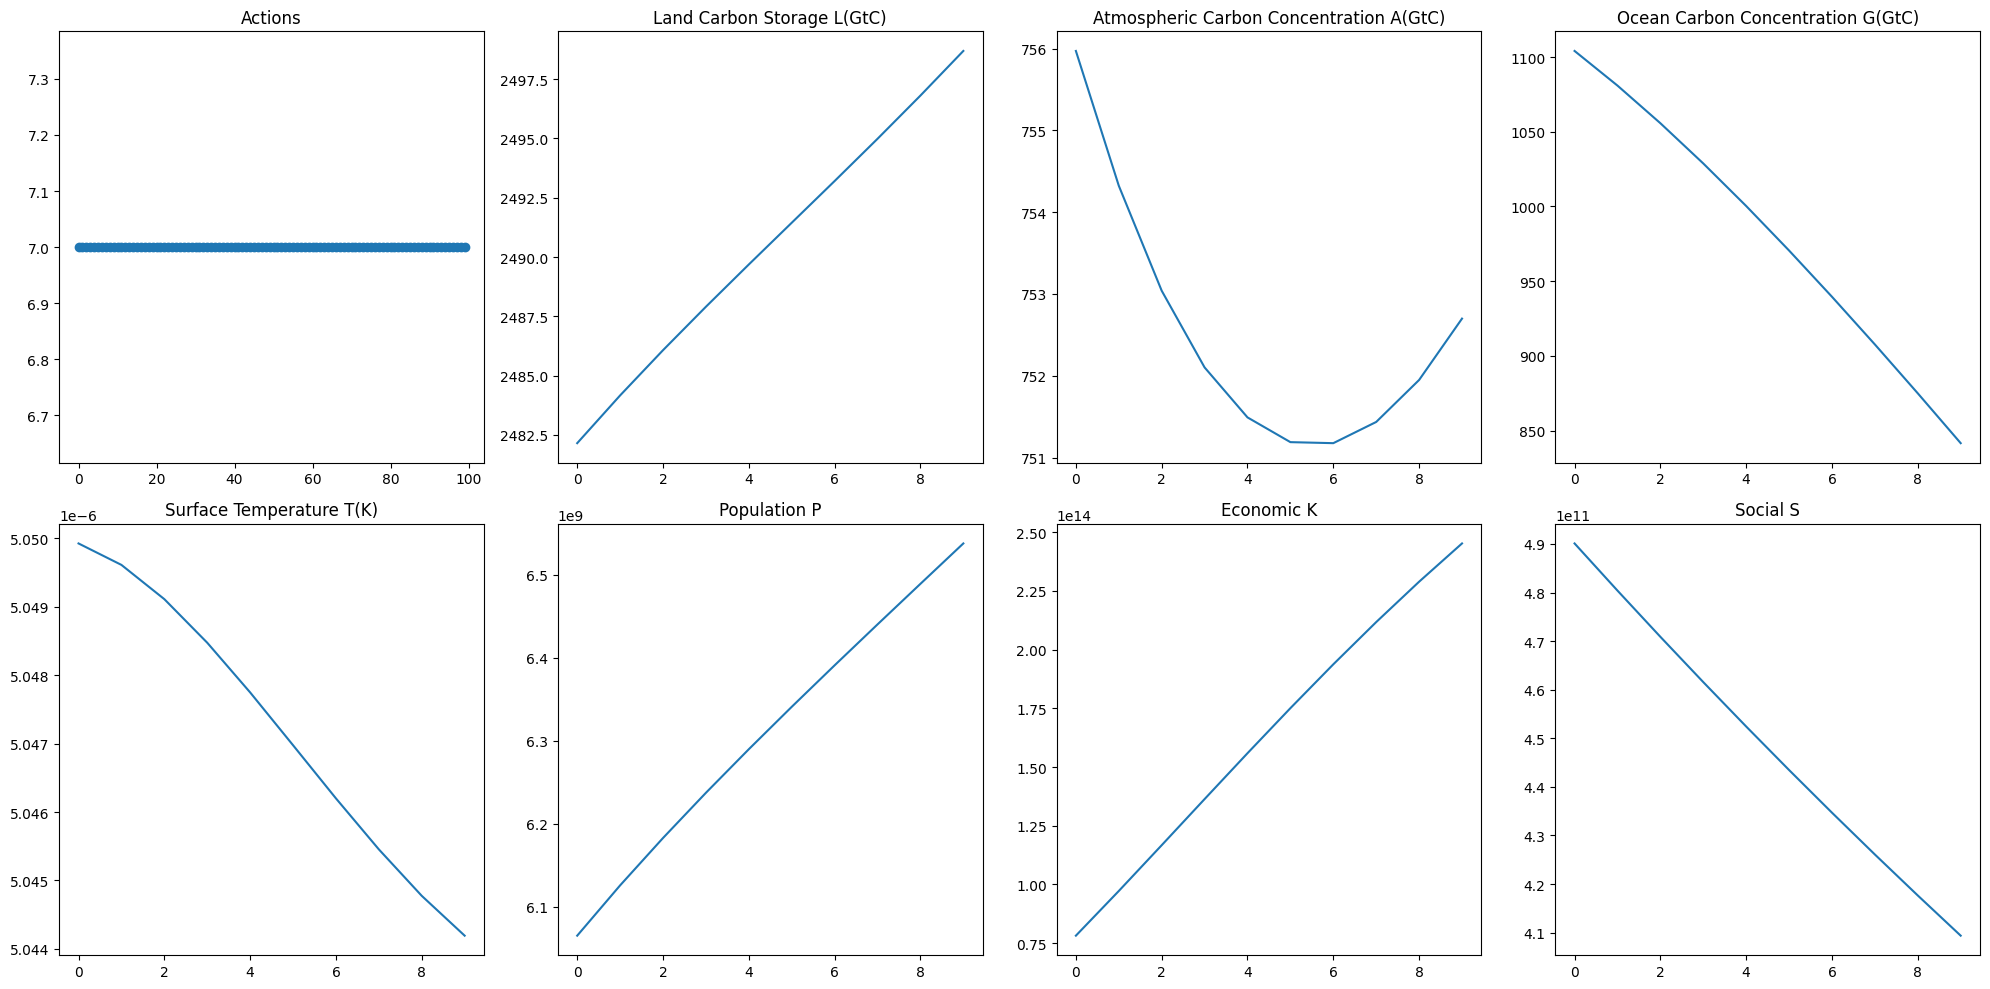

In [4]:
"""直接可以进行运行

"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

from gym import Env
from collections import OrderedDict

class DynEnv(Env):

    initials = dict(L=2480.,
               A=758, #830 ,
               G=1125,
               T=5.05e-6,
               P=6e9,
               K=6e13,
               S=5e11
               )
    params = dict(Sigma=1.5 * 1e8,
                Cstar=5500,
                a0=0.0298,
                aT=3200,
                l0=26.4,
                lT=1.1 * 1e6,
                delta=0.01,
                m=1.5,
                g=0.02, # greenhouse effect
                p=0.04,
                Wp=2000,
                q0=20,
                b=5.4 * 1e-7,
                yE=120,#147
                eB=4 * 1e10,
                eF=4 * 1e10,
                i=0.25,
                wL=0, #value varied
                k0=0.1,
                aB=1.5e4,#3e5,#value varied
                aF=2.7e5, #5e6, #value varied
                aR=9e-15, #7e-18, #?
                sS=1. / 50., #?
                sR=1.,#?
                ren_sub=.5,
                carbon_tax=.5,
                L0=2480.,
                )

    def __init__(self, action_number=3, reward_type=None):

        # Initialise class variables
        self.dt = 1
        self.action_number = action_number
        self.observation_space = len(self.initials.keys())

        self.carbon_tax = 0.5
        self.ren_sub = 0.5
        # self.cull = 1e7

        # We initialise the environment with a reset
        _ = self.reset()

        # Get the reward type
        self.reward_type = reward_type
        self.reward_function = self.get_reward_function(reward_type)

        # Planetary boundaries
        self.A_PB = 945
        self.W_PB = 7850
        self.P_PB = None
        self.PB_vec = np.array([self.A_PB, self.W_PB, self.P_PB])
        
        
        
        # 加入真实记录状态部分
        self.real_states = [] 

    def step(self, action_t) -> (np.array, float, bool):
        """The main step function where we call the others from"""

        # 这是来源于其他的部分补充的组件部分
        next_t = self.t + self.dt

        # we adjust the parameters given the actions taken
        # 开始时候操作我们定义为 action_0
        self.adjust_parameters(action_t)

        # we call the ode solver with the new parameters
        self.state = self.ode_solver(next_t)

        # Check if we have reached a final state
        if self.state_is_final():
            self.final_state = True

        reward = self.reward_function()
        self.t = next_t
        
        # 每次记录真实状态
        self.real_states.append(self.state)

        # 只有 state 需要正则化
        return self.normalise(self.state), reward, self.final_state

    def reset(self):
        """Resetting the environment at the start of an episode"""

        self.state = np.array(list(self.initials.values()))
        self.t = 0
        self.final_state = False
        self.np = False
        self.adjust_parameters()

        return self.state

    def ode_solver(self, next_t) -> np.array:
        """This is where we solve the dynamical system of equations to get the next state"""

        # we use the scipy ode solver: odeint
        ode_solutions = odeint(func=self.dynamic_eqs,
                               y0=self.state,
                               t=[self.t, next_t],
                               mxstep=10000)

        # we take the values of the variables on the last time step as our next state
        return ode_solutions[-1, :]

    def dynamic_eqs(self, LAGTPKS, t) -> list:
        """The differential equations we have to solve for the next step"""

        # We define variables for simpler notation
        def phot(A, T):
            """Photosynthesis"""
            return (self.params['l0'] - self.params['lT'] * T) * np.sqrt(A / self.params['Sigma'])

        def resp(T):
            """Respiration"""
            return self.params['a0'] + self.params['aT'] * T

        def diff(L, A, G=0.):
            """Diffusion between atmosphere and ocean"""
            return self.params['delta'] * (self.params['Cstar'] - L - G - (1 + self.params['m']) * A)

        def fert(W):
            """Human fertility rate"""
            return 2 * self.params['p'] * self.params['Wp'] * W / (self.params['Wp']**2 + W**2)

        def mort(W):
            """Human mortality rate"""
            return self.params['q0'] / W + self.params['wL']/self.params['Sigma']

        # We unpack the state variables and derived variables
        L, A, G, T, P, K, S = LAGTPKS
        
        B, F, R, Y, W = self.compute_derived_variables()

        # clamp here
        L = np.amin([np.amax([L, 1e-12]), self.params['Cstar']])
        A = np.amin([np.amax([A, 1e-12]), self.params['Cstar']])
        G = np.amin([np.amax([G, 1e-12]), self.params['Cstar']])
        T = np.amax([T, 1e-12])
        P = np.amax([P, 1e-12])
        K = np.amax([K, 1e-12])
        S = np.amax([S, 1e-12])

        # odes to solve
        dL = (phot(A, T) - resp(T)) * L - B
        dA = -dL + diff(L, A, G=G)
        dG = -F
        dT = self.params['g'] * (A / self.params['Sigma'] - T)
        dP = P * (fert(W) - mort(W))
        dK = self.params['i'] * Y - self.params['k0'] * K
        dS = self.params['sR'] * R - self.params['sS'] * S

        return [dL, dA, dG, dT, dP, dK, dS] # 关键的 ode 计算的部分

    def compute_derived_variables(self) -> tuple:
        """Compute the variables that depend on the state variables"""

        # Unpack state variables
        L, A, G, T, P, K, S = self.state

        if self.np:
            Leff = max(L-self.params['L0'], 0)
        else:
            Leff = L

        # Recurrent variables for simpler computation
        Xb = self.params['aB'] * Leff ** 2.
        Xf = self.params['aF'] * G ** 2.
        Xr = self.params['aR'] * S ** 2.
        X = Xb + Xf + Xr
        Z = (P * K) ** (2 / 5) / X ** (4 / 5)

        # derived variables
        B = Xb * Z / self.params['eB']
        F = Xf * Z / self.params['eF']
        R = Xr * Z
        Y = self.params['yE'] * (self.params['eB'] * B + self.params['eF'] * F + R)
        W = (1. - self.params['i']) * Y / P + self.params['wL'] * Leff / self.params['Sigma']

        return B, F, R, Y, W

    def adjust_parameters(self, a_t=0):
        """Adjust the parameters before computing the ODE by using the actions"""
        # 它的作用是将整数a_t转换为其对应的二进制表示，并以列表的形式返回。
        # ['0', '1', '0']
        # 随机转换的 2元组
        # action = (list(np.binary_repr(a_t, width=self.action_number)))
        # action.reverse() # 为了使列表中的二进制位按照正确的顺序排列
        
        # 翻译 action 变为 [0,0,0] 形式
        if a_t == 0:
            action = [0,0,0]
            print('action 0, default')
        elif a_t == 1:
            action = [0,1,1]
            print('action 1, sbsidy')
        elif a_t == 2:
            action = [1,0,1]
            print('action 2, carbon tax')
        elif a_t == 3:
            action = [1,1,0]
            print('action 3, natural protection')
        elif a_t == 4:
            action = [0,0,1]
            print('action 4, subsidy and carbon tax')
        elif a_t == 5:
            action = [0,1,0]
            print('action 5, subsidy and natural protection')
        elif a_t == 6:
            action = [1,0,0]
            print('action 6, carbon tax and natural protection')
        elif a_t == 7:
            action = [1,1,1]
            print('action 7, all')
        
    
        aR_default = 7e-18
        aF_default = 5e6
        aB_default = 3e5
        # # TODO extend this to multiple dimensions
        # self.params['aR'] = aR_default * (1 + 0.3*action[0])
        # self.params['aB'] = aB_default * (1 + 0.3*action[1])
        # self.params['aF'] = aF_default * (1 + 0.3*action[2])
        if int(action[0]):
            self.params['aR'] = aR_default*(1+self.ren_sub)
        else:
            self.params['aR'] = aR_default
        # carbon tax
        if int(action[1]):
            self.params['aB'] = aB_default*(1-self.carbon_tax)
            self.params['aF'] = aF_default*(1-self.carbon_tax)
        else:
            self.params['aB'] = aB_default
            self.params['aF'] = aF_default

        # 我猜是其中基本保护的部分操作
        if int(action[2]):
            self.np = True
        else:
            self.np = False

        # if int(action[3]):
        #     self.state[4] -= self.cull



    def normalise(self, cur_state):
        return np.array(cur_state)/(np.array(list(self.initials.values()))+np.array(cur_state))
        # return np.array(cur_state)        

    def get_env(self, env_type):
        pass

    def get_reward_function(self, reward_type):
        """Choosing a reward function"""


        def planet_boundaries():
            _, A, _, _, P, _, _ = self.state
            # _, _, _, _, W = self.compute_derived_variables()
            # state_vec = np.array([A, W/18588, P])
            # r_t = np.linalg.norm(state_vec - self.PB_vec)
            if self.inside_planetary_boundaries():
                return round(np.sqrt(self.A_PB - A), 1)
            return 0

        return planet_boundaries

    def state_is_final(self) -> bool:
        """Check to see if we are in a terminal state"""

        if not self.inside_planetary_boundaries():
            return True
        return False
    
    

    def inside_planetary_boundaries(self) -> bool:
        """Check if we are inside the planetary boundaries"""
        self.adjust_parameters()
        _, A, _, _, P, _, _ = self.state
        _, _, _, _, W = self.compute_derived_variables()

        if A < self.A_PB: #and W > self.W_PB and P > self.P_PB:
            return True
        return False

env = DynEnv()
states = []
actions = []


# default
# [actions.append(0) for i in range(100)]

# carbon tax 
# [actions.append(2) for i in range(100)]

# subsidy + carbon tax + natural protection
[actions.append(7) for i in range(100)]


# 这是基本循环的部分
for i in range(10):
    action = actions[i] # 对应其中的策略采样的部分
    state, reward, done = env.step(action)
    # 注意其中单步的 state 和 states 不一样
    states.append(state[0:])
    print(env.state)
    if done:
        # 有可能是提前结束了
        print(i, 'done')
        break


#

# 将所有的 states 都反归一化操作

# 绘制状态值和动作
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

# 绘制 actions
# 在 [0,0] 散点图中绘制 actions，要求使用散点图
axs[0, 0].scatter(range(len(actions)), actions)
axs[0, 0].set_title('Actions')

# 绘制状态值

states = env.real_states
states = np.array(states)

# 绘制各个状态变量随时间步变化的曲线
axs[0, 1].plot(range(len(states[:, 0])), states[:, 0])
axs[0, 1].set_title('Land Carbon Storage L(GtC)')

axs[0, 2].plot(range(len(states[:, 1])), states[:, 1])
axs[0, 2].set_title('Atmospheric Carbon Concentration A(GtC)')

axs[0, 3].plot(range(len(states[:, 2])), states[:, 2])
axs[0, 3].set_title('Ocean Carbon Concentration G(GtC)')

axs[1, 0].plot(range(len(states[:, 3])), states[:, 3])
axs[1, 0].set_title('Surface Temperature T(K)')

axs[1, 1].plot(range(len(states[:, 4])), states[:, 4])
axs[1, 1].set_title('Population P')

axs[1, 2].plot(range(len(states[:, 5])), states[:, 5])
axs[1, 2].set_title('Economic K')

axs[1, 3].plot(range(len(states[:,6])), states[:, 6])
axs[1, 3].set_title('Social S')

plt.tight_layout()
plt.show()



### 尝试反归一化数值变化

是的，如果你在训练过程中对状态进行了归一化操作，那么在绘制真实状态值时需要进行反归一化操作，以恢复原始的状态值。反归一化操作的目的是将归一化后的值转换回原始的尺度。

假设你的归一化操作是：

\[ \text{normalised}(s) = \frac{s}{s_0 + s} \]

那么反归一化操作可以表示为：

\[ s = \frac{\text{normalised}(s) \cdot s_0}{1 - \text{normalised}(s)} \]

其中 \( s_0 \) 是初始化状态。


> 也就是每一次 state 归一化之后再反归一化操作一下

- 失败了

action 0, default
action 0, default
action 0, default
action 0, default
[2.47664845e+03 7.61423396e+02 1.10541965e+03 5.05029394e-06
 6.05452486e+09 8.31695945e+13 4.90099551e+11]
action 0, default
action 0, default
action 0, default
[2.47262999e+03 7.65663157e+02 1.08331453e+03 5.05108849e-06
 6.10352060e+09 1.08100596e+14 4.80395171e+11]
action 0, default
action 0, default
action 0, default
[2.46801687e+03 7.70657089e+02 1.05905409e+03 5.05247735e-06
 6.14859813e+09 1.34177478e+14 4.70882974e+11]
action 0, default
action 0, default
action 0, default
[2.46286357e+03 7.76358017e+02 1.03297519e+03 5.05454516e-06
 6.19079279e+09 1.60893570e+14 4.61559152e+11]
action 0, default
action 0, default
action 0, default
[2.45721029e+03 7.82730330e+02 1.00538715e+03 5.05736940e-06
 6.23081214e+09 1.87832077e+14 4.52419974e+11]
action 0, default
action 0, default
action 0, default
[2.45108580e+03 7.89747348e+02 9.76575331e+02 5.06102196e-06
 6.26916339e+09 2.14651176e+14 4.43461782e+11]
action 0, 

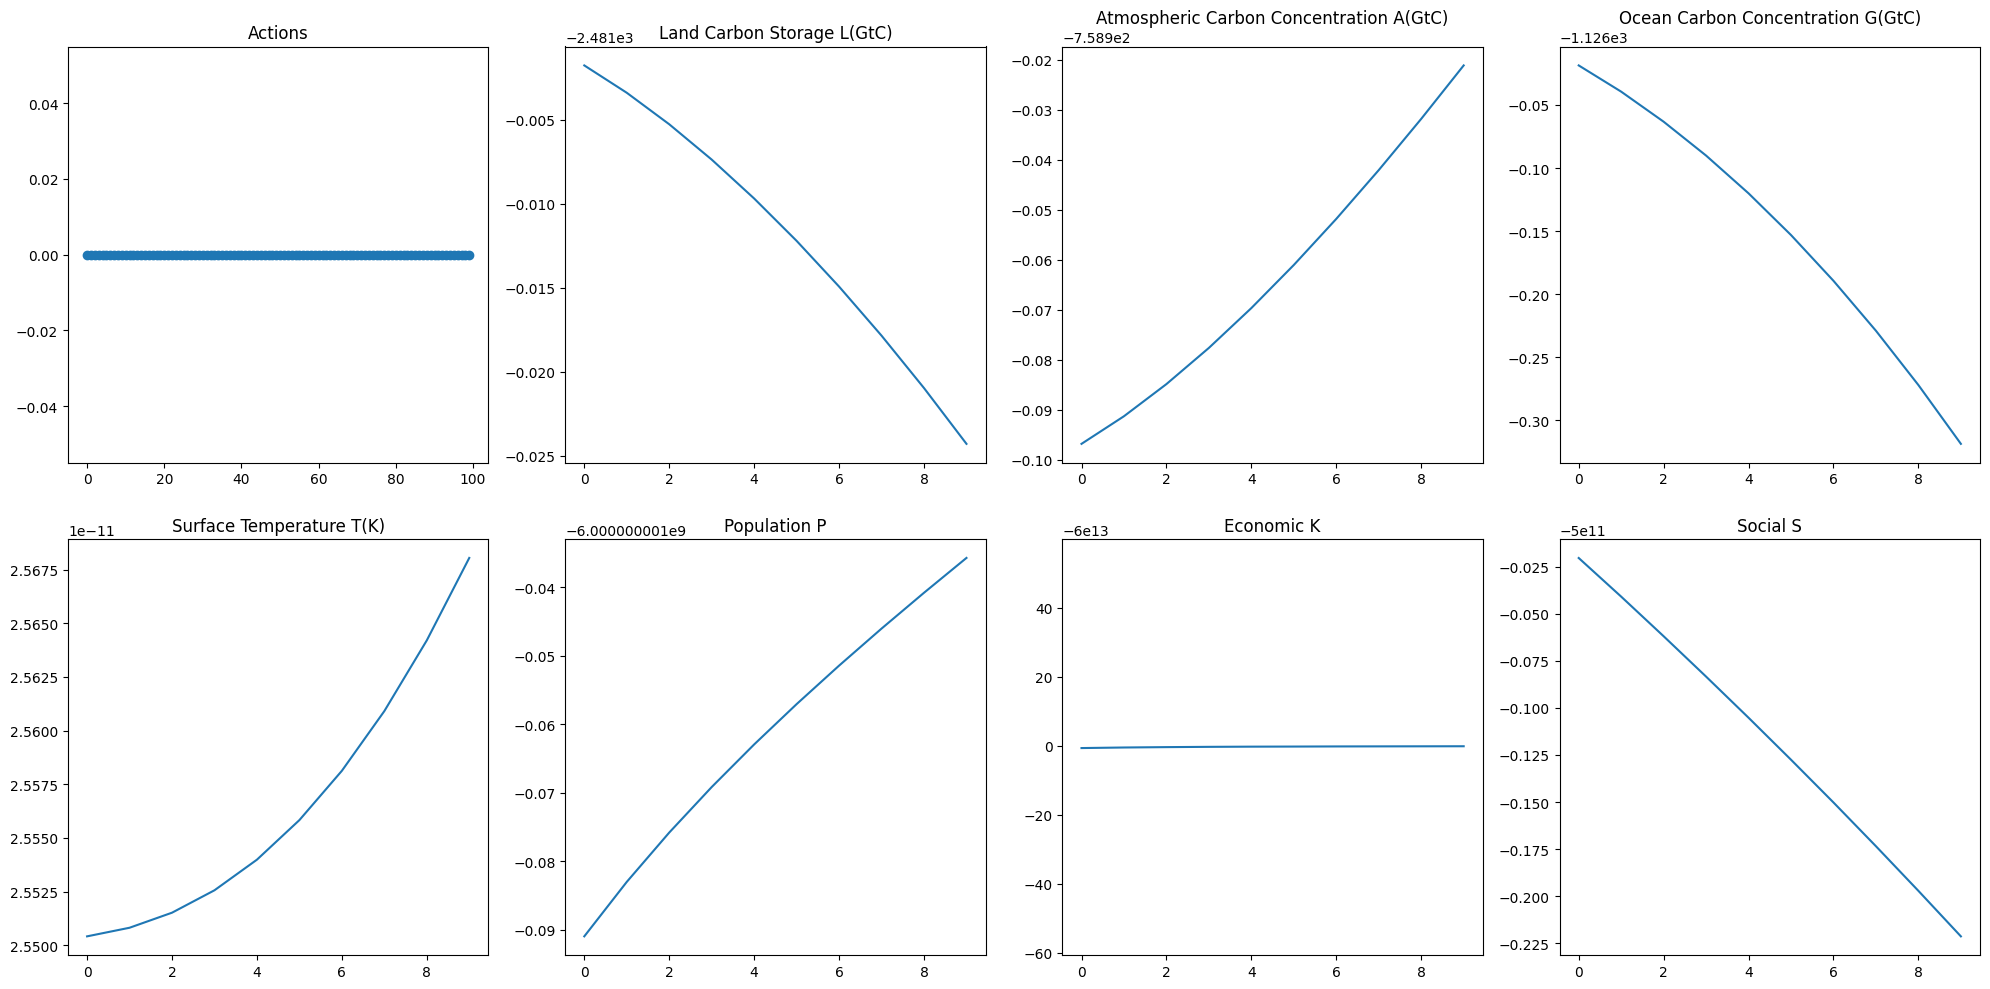

In [47]:
# """直接可以进行运行

# """

# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.integrate import odeint

# from gym import Env
# from collections import OrderedDict

# class DynEnv(Env):

#     initials = dict(L=2480.,
#                A=758, #830 ,
#                G=1125,
#                T=5.05e-6,
#                P=6e9,
#                K=6e13,
#                S=5e11
#                )
#     params = dict(Sigma=1.5 * 1e8,
#                 Cstar=5500,
#                 a0=0.0298,
#                 aT=3200,
#                 l0=26.4,
#                 lT=1.1 * 1e6,
#                 delta=0.01,
#                 m=1.5,
#                 g=0.02, # greenhouse effect
#                 p=0.04,
#                 Wp=2000,
#                 q0=20,
#                 b=5.4 * 1e-7,
#                 yE=120,#147
#                 eB=4 * 1e10,
#                 eF=4 * 1e10,
#                 i=0.25,
#                 wL=0, #value varied
#                 k0=0.1,
#                 aB=1.5e4,#3e5,#value varied
#                 aF=2.7e5, #5e6, #value varied
#                 aR=9e-15, #7e-18, #?
#                 sS=1. / 50., #?
#                 sR=1.,#?
#                 ren_sub=.5,
#                 carbon_tax=.5,
#                 L0=2480.,
#                 )

#     def __init__(self, action_number=3, reward_type=None):

#         # Initialise class variables
#         self.dt = 1
#         self.action_number = action_number
#         self.observation_space = len(self.initials.keys())

#         self.carbon_tax = 0.5
#         self.ren_sub = 0.5
#         # self.cull = 1e7

#         # We initialise the environment with a reset
#         _ = self.reset()

#         # Get the reward type
#         self.reward_type = reward_type
#         self.reward_function = self.get_reward_function(reward_type)

#         # Planetary boundaries
#         self.A_PB = 945
#         self.W_PB = 7850
#         self.P_PB = None
#         self.PB_vec = np.array([self.A_PB, self.W_PB, self.P_PB])
        
        
#         # 添加真实记录状态部分
#         self.real_states= []

#     def step(self, action_t) -> (np.array, float, bool):
#         """The main step function where we call the others from"""

#         # 这是来源于其他的部分补充的组件部分
#         next_t = self.t + self.dt

#         # we adjust the parameters given the actions taken
#         # 开始时候操作我们定义为 action_0
#         self.adjust_parameters(action_t)

#         # we call the ode solver with the new parameters
#         self.state = self.ode_solver(next_t)

#         # Check if we have reached a final state
#         if self.state_is_final():
#             self.final_state = True

#         reward = self.reward_function()
#         self.t = next_t
        
#         inver_normalized_state = self.denormalise(self.state)
#         self.real_states.append(inver_normalized_state)

#         # 只有 state 需要正则化
#         return self.normalise(self.state), reward, self.final_state

#     def reset(self):
#         """Resetting the environment at the start of an episode"""

#         self.state = np.array(list(self.initials.values()))
#         self.t = 0
#         self.final_state = False
#         self.np = False
#         self.adjust_parameters()

#         return self.state

#     def ode_solver(self, next_t) -> np.array:
#         """This is where we solve the dynamical system of equations to get the next state"""

#         # we use the scipy ode solver: odeint
#         ode_solutions = odeint(func=self.dynamic_eqs,
#                                y0=self.state,
#                                t=[self.t, next_t],
#                                mxstep=10000)

#         # we take the values of the variables on the last time step as our next state
#         return ode_solutions[-1, :]

#     def dynamic_eqs(self, LAGTPKS, t) -> list:
#         """The differential equations we have to solve for the next step"""

#         # We define variables for simpler notation
#         def phot(A, T):
#             """Photosynthesis"""
#             return (self.params['l0'] - self.params['lT'] * T) * np.sqrt(A / self.params['Sigma'])

#         def resp(T):
#             """Respiration"""
#             return self.params['a0'] + self.params['aT'] * T

#         def diff(L, A, G=0.):
#             """Diffusion between atmosphere and ocean"""
#             return self.params['delta'] * (self.params['Cstar'] - L - G - (1 + self.params['m']) * A)

#         def fert(W):
#             """Human fertility rate"""
#             return 2 * self.params['p'] * self.params['Wp'] * W / (self.params['Wp']**2 + W**2)

#         def mort(W):
#             """Human mortality rate"""
#             return self.params['q0'] / W + self.params['wL']/self.params['Sigma']

#         # We unpack the state variables and derived variables
#         L, A, G, T, P, K, S = LAGTPKS
        
#         B, F, R, Y, W = self.compute_derived_variables()

#         # clamp here
#         L = np.amin([np.amax([L, 1e-12]), self.params['Cstar']])
#         A = np.amin([np.amax([A, 1e-12]), self.params['Cstar']])
#         G = np.amin([np.amax([G, 1e-12]), self.params['Cstar']])
#         T = np.amax([T, 1e-12])
#         P = np.amax([P, 1e-12])
#         K = np.amax([K, 1e-12])
#         S = np.amax([S, 1e-12])

#         # odes to solve
#         dL = (phot(A, T) - resp(T)) * L - B
#         dA = -dL + diff(L, A, G=G)
#         dG = -F
#         dT = self.params['g'] * (A / self.params['Sigma'] - T)
#         dP = P * (fert(W) - mort(W))
#         dK = self.params['i'] * Y - self.params['k0'] * K
#         dS = self.params['sR'] * R - self.params['sS'] * S

#         return [dL, dA, dG, dT, dP, dK, dS] # 关键的 ode 计算的部分

#     def compute_derived_variables(self) -> tuple:
#         """Compute the variables that depend on the state variables"""

#         # Unpack state variables
#         L, A, G, T, P, K, S = self.state

#         if self.np:
#             Leff = max(L-self.params['L0'], 0)
#         else:
#             Leff = L

#         # Recurrent variables for simpler computation
#         Xb = self.params['aB'] * Leff ** 2.
#         Xf = self.params['aF'] * G ** 2.
#         Xr = self.params['aR'] * S ** 2.
#         X = Xb + Xf + Xr
#         Z = (P * K) ** (2 / 5) / X ** (4 / 5)

#         # derived variables
#         B = Xb * Z / self.params['eB']
#         F = Xf * Z / self.params['eF']
#         R = Xr * Z
#         Y = self.params['yE'] * (self.params['eB'] * B + self.params['eF'] * F + R)
#         W = (1. - self.params['i']) * Y / P + self.params['wL'] * Leff / self.params['Sigma']

#         return B, F, R, Y, W

#     def adjust_parameters(self, a_t=0):
#         """Adjust the parameters before computing the ODE by using the actions"""
#         # 它的作用是将整数a_t转换为其对应的二进制表示，并以列表的形式返回。
#         # ['0', '1', '0']
#         # 随机转换的 2元组
#         # action = (list(np.binary_repr(a_t, width=self.action_number)))
#         # action.reverse() # 为了使列表中的二进制位按照正确的顺序排列
        
#         # 翻译 action 变为 [0,0,0] 形式
#         if a_t == 0:
#             action = [0,0,0]
#             print('action 0, default')
#         elif a_t == 1:
#             action = [0,1,1]
#             print('action 1, sbsidy')
#         elif a_t == 2:
#             action = [1,0,1]
#             print('action 2, carbon tax')
#         elif a_t == 3:
#             action = [1,1,0]
#             print('action 3, natural protection')
#         elif a_t == 4:
#             action = [0,0,1]
#             print('action 4, subsidy and carbon tax')
#         elif a_t == 5:
#             action = [0,1,0]
#             print('action 5, subsidy and natural protection')
#         elif a_t == 6:
#             action = [1,0,0]
#             print('action 6, carbon tax and natural protection')
#         elif a_t == 7:
#             action = [1,1,1]
#             print('action 7, all')
        
    
#         aR_default = 7e-18
#         aF_default = 5e6
#         aB_default = 3e5
#         # # TODO extend this to multiple dimensions
#         # self.params['aR'] = aR_default * (1 + 0.3*action[0])
#         # self.params['aB'] = aB_default * (1 + 0.3*action[1])
#         # self.params['aF'] = aF_default * (1 + 0.3*action[2])
#         if int(action[0]):
#             self.params['aR'] = aR_default*(1+self.ren_sub)
#         else:
#             self.params['aR'] = aR_default
#         # carbon tax
#         if int(action[1]):
#             self.params['aB'] = aB_default*(1-self.carbon_tax)
#             self.params['aF'] = aF_default*(1-self.carbon_tax)
#         else:
#             self.params['aB'] = aB_default
#             self.params['aF'] = aF_default

#         # 我猜是其中基本保护的部分操作
#         if int(action[2]):
#             self.np = True
#         else:
#             self.np = False

#         # if int(action[3]):
#         #     self.state[4] -= self.cull



#     def normalise(self, cur_state):
#         return np.array(cur_state)/(np.array(list(self.initials.values()))+np.array(cur_state))
#         # return np.array(cur_state)     
        
#     def denormalise(self, norm_state):
#         s0 = np.array(list(self.initials.values()))
#         return norm_state * s0 / (1 - norm_state)
        
           

#     def get_env(self, env_type):
#         pass

#     def get_reward_function(self, reward_type):
#         """Choosing a reward function"""


#         def planet_boundaries():
#             _, A, _, _, P, _, _ = self.state
#             # _, _, _, _, W = self.compute_derived_variables()
#             # state_vec = np.array([A, W/18588, P])
#             # r_t = np.linalg.norm(state_vec - self.PB_vec)
#             if self.inside_planetary_boundaries():
#                 return round(np.sqrt(self.A_PB - A), 1)
#             return 0

#         return planet_boundaries

#     def state_is_final(self) -> bool:
#         """Check to see if we are in a terminal state"""

#         if not self.inside_planetary_boundaries():
#             return True
#         return False
    
    

#     def inside_planetary_boundaries(self) -> bool:
#         """Check if we are inside the planetary boundaries"""
#         self.adjust_parameters()
#         _, A, _, _, P, _, _ = self.state
#         _, _, _, _, W = self.compute_derived_variables()

#         if A < self.A_PB: #and W > self.W_PB and P > self.P_PB:
#             return True
#         return False

# env = DynEnv()
# states = []
# actions = []


# # default
# [actions.append(0) for i in range(100)]

# # carbon tax 
# # [actions.append(2) for i in range(100)]

# # subsidy + carbon tax + natural protection
# # [actions.append(7) for i in range(100)]


# # 这是基本循环的部分
# for i in range(10):
#     state, reward, done = env.step(actions[i])
#     # 注意其中单步的 state 和 states 不一样
#     states.append(state[0:])
#     print(env.state)
#     if done:
#         # 有可能是提前结束了
#         print(i, 'done')
#         break


# #

# # 将所有的 states 都反归一化操作

# # 绘制状态值和动作
# fig, axs = plt.subplots(2, 4, figsize=(20, 10))

# # 绘制 actions
# # 在 [0,0] 散点图中绘制 actions，要求使用散点图
# axs[0, 0].scatter(range(len(actions)), actions)
# axs[0, 0].set_title('Actions')

# # 绘制状态值

# real_states = env.real_states
# states = np.array(real_states)

# # 绘制各个状态变量随时间步变化的曲线
# axs[0, 1].plot(range(len(states[:, 0])), states[:, 0])
# axs[0, 1].set_title('Land Carbon Storage L(GtC)')

# axs[0, 2].plot(range(len(states[:, 1])), states[:, 1])
# axs[0, 2].set_title('Atmospheric Carbon Concentration A(GtC)')

# axs[0, 3].plot(range(len(states[:, 2])), states[:, 2])
# axs[0, 3].set_title('Ocean Carbon Concentration G(GtC)')

# axs[1, 0].plot(range(len(states[:, 3])), states[:, 3])
# axs[1, 0].set_title('Surface Temperature T(K)')

# axs[1, 1].plot(range(len(states[:, 4])), states[:, 4])
# axs[1, 1].set_title('Population P')

# axs[1, 2].plot(range(len(states[:, 5])), states[:, 5])
# axs[1, 2].set_title('Economic K')

# axs[1, 3].plot(range(len(states[:,6])), states[:, 6])
# axs[1, 3].set_title('Social S')

# plt.tight_layout()
# plt.show()

